<a href="https://colab.research.google.com/github/mostafa-ja/Anomaly-detection/blob/main/TCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Temporal Convolutional Networks and Forecasting](https://unit8.com/resources/temporal-convolutional-networks-and-forecasting/)



```
torch.nn.Conv1d(in_channels, out_channels, kernel_size, stride=1, padding=0,
 dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)

in_channels (int) – Number of channels(features) in the input image

out_channels (int) – Number of channels(features) produced by the convolution

kernel_size (int or tuple) – Size of the convolving kernel

stride (int or tuple, optional) – Stride(step) of the convolution. Default: 1

padding (int, tuple or str, optional) – Padding added to both sides of the input. Default: 0

padding_mode (str, optional) – 'zeros', 'reflect', 'replicate' or 'circular'. Default: 'zeros'

dilation (int or tuple, optional) – Spacing between kernel elements. Default: 1

groups (int, optional) – Number of blocked connections from input channels to output channels. Default: 1

bias (bool, optional) – If True, adds a learnable bias to the output. Default: True


```



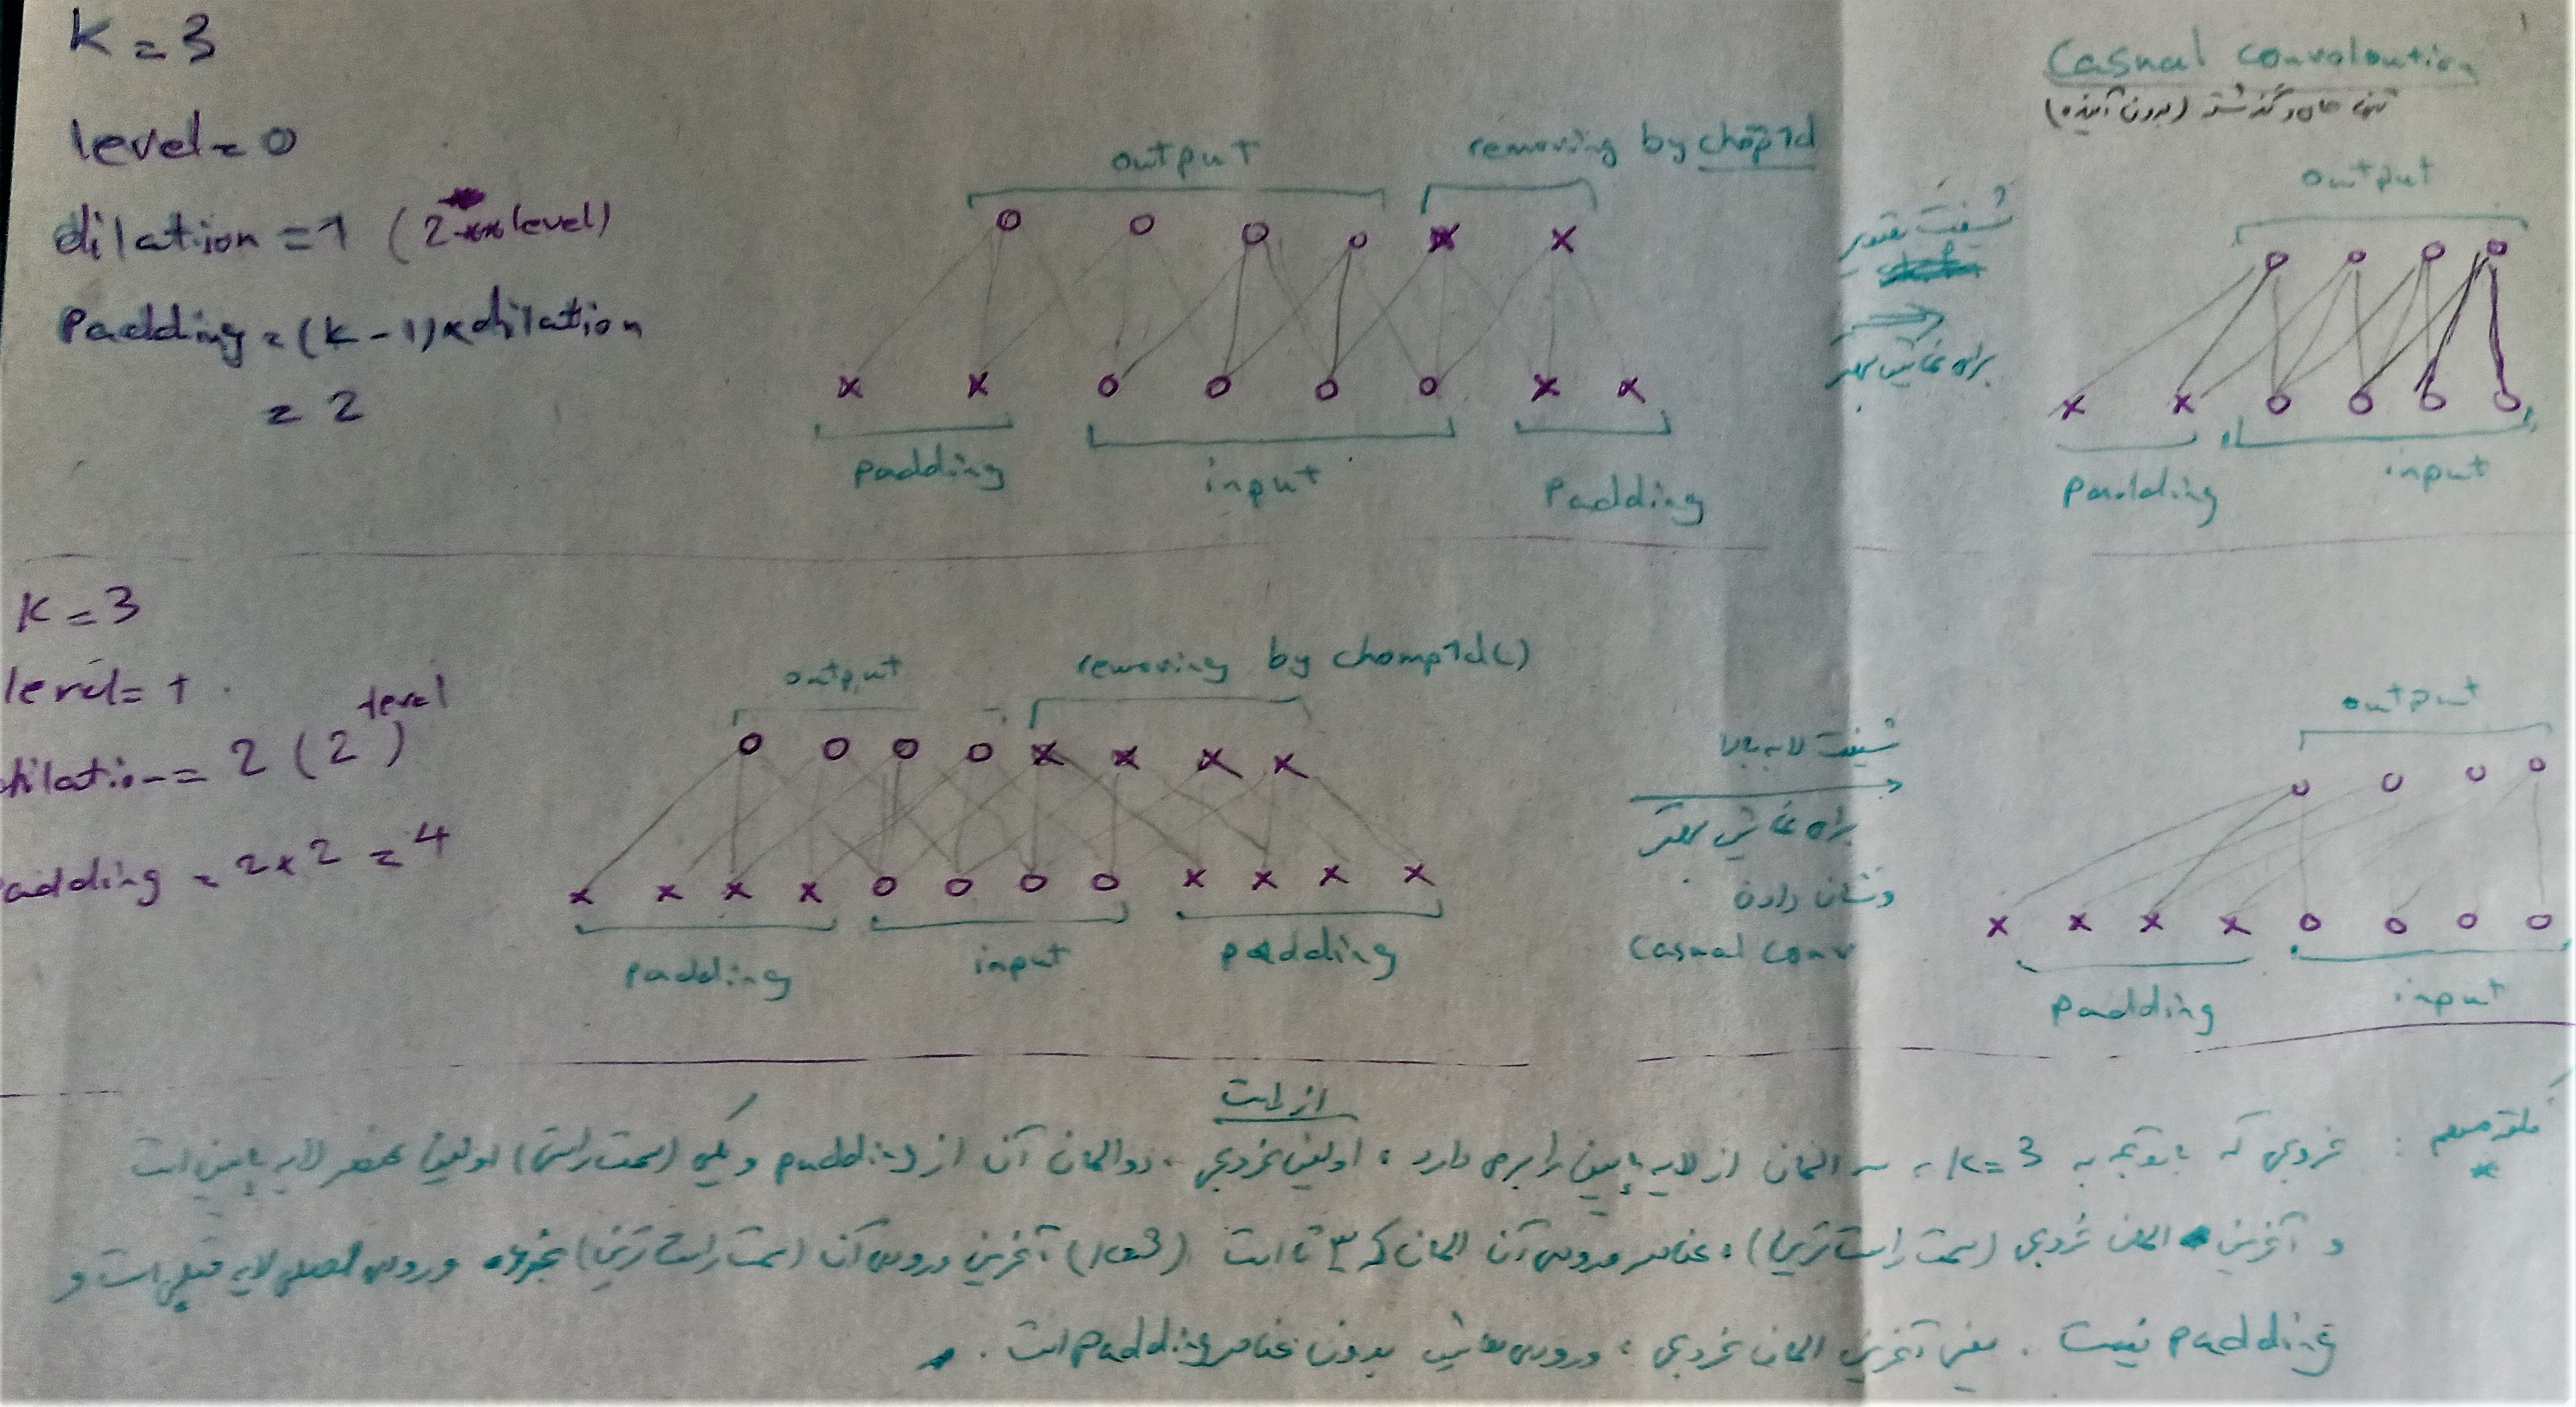

In [ ]:
from torch.autograd.grad_mode import no_grad
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm


def Chomp1d(x):
    return x[:, :, :-padding]

with no_grad():
  kernel_size = 3
  num_level = 0
  dilation_size = 2 ** num_level
  padding=(kernel_size-1) * dilation_size
  m = nn.Conv1d(1, 1, kernel_size, stride=1, padding = padding,dilation=dilation_size)

  # Change the kernel's value in the first convolutional layer
  new_kernel_value = torch.tensor([[[ 1.0, 1.0, 1.0]]])  # Replace with your desired kernel values
  m.weight = nn.Parameter(new_kernel_value)

  #input = torch.randn(1, 1, 4)
  input = torch.tensor([[[1.0,1.0,1.0,1.0]]]) #input.shape = (1,1,4)  #(batch_size, input_size(number of channels=input feature), input_length(length of signal sequence))
  output = m(input)
  print('output.shape          = ',output.shape)
  print('Chomp1d(output).shape = ',Chomp1d(output).shape)
  print('output          = ',output)
  print('Chomp1d(output) = ',Chomp1d(output))

output.shape          =  torch.Size([1, 1, 6])
Chomp1d(output).shape =  torch.Size([1, 1, 4])
output          =  tensor([[[1.3664, 2.3664, 3.3664, 3.3664, 2.3664, 1.3664]]])
Chomp1d(output) =  tensor([[[1.3664, 2.3664, 3.3664, 3.3664]]])


In [ ]:
with no_grad():
  kernel_size = 3
  num_level = 1
  dilation_size = 2 ** num_level
  padding=(kernel_size-1) * dilation_size
  m = nn.Conv1d(1, 1, kernel_size, stride=1, padding = padding,dilation=dilation_size)

  # Change the kernel's value in the first convolutional layer
  new_kernel_value = torch.tensor([[[ 1.0, 1.0, 1.0]]])  # Replace with your desired kernel values
  m.weight = nn.Parameter(new_kernel_value)

  #input = torch.randn(1, 1, 4)
  input = torch.tensor([[[1.0,1.0,1.0,1.0]]]) #input.shape = (1,1,4)  #(batch_size, input_size(number of channels=input feature), input_length(length of signal sequence))
  output = m(input)
  print('output.shape          = ',output.shape)
  print('Chomp1d(output).shape = ',Chomp1d(output).shape)
  print('output          = ',output)
  print('Chomp1d(output) = ',Chomp1d(output))

output.shape          =  torch.Size([1, 1, 8])
Chomp1d(output).shape =  torch.Size([1, 1, 4])
output          =  tensor([[[1.3814, 1.3814, 2.3814, 2.3814, 2.3814, 2.3814, 1.3814, 1.3814]]])
Chomp1d(output) =  tensor([[[1.3814, 1.3814, 2.3814, 2.3814]]])


In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)




import torch.nn.functional as F

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)

    def forward(self, inputs):
        """Inputs have to have dimension (N, C_in, L_in)"""
        y = self.tcn(inputs)  # input should have dimension (N, C, L)
        print(y.shape)
        o = self.linear(y[:, :, -1])
        return F.log_softmax(o, dim=1)

In [ ]:
# Define the TemporalConvNet model
input_size = 28
output_size = 28
num_channels = [64, 64, 64]  # Customize the number of channels in each layer as needed
kernel_size = 3
dropout = 0.2
tcn_model = TCN(input_size, output_size, num_channels, kernel_size, dropout)

In [ ]:
input_sequence = torch.tensor(np.random.randint(2, size=(1, 28, 9)), dtype=torch.float32)
input_sequence.shape

torch.Size([1, 28, 9])

In [ ]:
tcn_model(input_sequence).shape

torch.Size([1, 28])

In [ ]:
tcn_model(input_sequence)

tensor([[-2.2432, -2.2679, -3.4947, -1.8294, -2.1480, -2.3906, -1.7722, -1.9197,
         -3.5647, -1.5875, -2.6961, -1.9295, -2.3001, -3.0480, -2.3446, -1.7244,
         -2.8435, -2.2449, -2.1142, -1.5072, -2.0405, -1.3799, -1.3849, -1.8793,
         -3.0311, -1.2516, -1.4220, -2.1361]], grad_fn=<SliceBackward0>)

In [ ]:
import torch
import torch.nn.functional as F

# Suppose we have some logits for three classes
logits = torch.tensor([[2.0, 1.0, 0.1], [1.0, 2.0, 0.1]])
print(logits.shape)
# Apply log_softmax along the last dimension (dim=-1)
log_probs = F.log_softmax(logits, dim=-1)
probs = F.softmax(logits, dim=-1)
print(probs)
print(log_probs)


torch.Size([2, 3])
tensor([[0.6590, 0.2424, 0.0986],
        [0.2424, 0.6590, 0.0986]])
tensor([[-0.4170, -1.4170, -2.3170],
        [-1.4170, -0.4170, -2.3170]])


In [18]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        """
        Removes the extra elements at the end of the input tensor along the time dimension.

        Args:
        - chomp_size (int): The number of elements to be removed from the end of each input tensor.
        """
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        """
        Forward pass of Chomp1d.

        Args:
        - x (torch.Tensor): Input tensor with dimension (N, C, L). (batch size, number of input features(channels), input sequence length)

        Returns:
        - torch.Tensor: Output tensor with dimension (N, C, L - chomp_size).
        """
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        """
        A single temporal block in the Temporal Convolutional Network.

        Args:
        - n_inputs (int): Number of input channels.
        - n_outputs (int): Number of output channels.
        - kernel_size (int): Size of the convolutional kernels.
        - stride (int): Stride for the convolutional layers.
        - dilation (int): Dilation rate for the convolutional layers.
        - padding (int): Padding size for the convolutional layers.
        - dropout (float): Dropout rate to be applied after each convolutional layer.
        """
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)

        # The downsample variable stores a 1x1 convolutional layer
        # (if n_inputs is not equal to n_outputs) to match the input and output dimensions of the block. Otherwise, it is set to None.
        #IMPORTANT : The purpose of self.downsample is to adjust the dimensions of the input tensor so that it can be added element-wise to the output of the
        #temporal block,This addition is part of the residual connection that helps with training deeper networks and improves gradient flow during
        # backpropagation. CAREFUL, because here we have kernel size one, we dont need  Chomp1d() to equlize their size
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None

        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        """
        Initialize the weights of the convolutional layers with a normal distribution (mean=0, std=0.01).
        """
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        """
        Forward pass of TemporalBlock.

        Args:
        - x (torch.Tensor): Input tensor with dimension (N, C, L).

        Returns:
        - torch.Tensor: Output tensor with dimension (N, C, L).
        """
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        """
        Temporal Convolutional Network (TCN) for sequence processing.
        This class represents the Temporal Convolutional Network (TCN) architecture that contains multiple temporal blocks stacked together.

        Args:
        - num_inputs (int): Number of input channels.
        - num_channels (list of int): Number of channels for each temporal block.
        - kernel_size (int): Size of the convolutional kernels in the temporal blocks.
        - dropout (float): Dropout rate to be applied after each temporal block.
        """
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            #The input channels for each block are determined based on the number of input channels (num_inputs) for the first block,
            #and for subsequent blocks, the number of input channels is set to the number of output channels of the previous block (num_channels[i-1]).
            in_channels = num_inputs if i == 0 else num_channels[i - 1]
            out_channels = num_channels[i]

            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size - 1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass of TemporalConvNet.

        Args:
        - x (torch.Tensor): Input tensor with dimension (N, C, L).

        Returns:
        - torch.Tensor: Output tensor with dimension (N, C, L).
        """
        return self.network(x)



class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        """
        Temporal Convolutional Network (TCN) for sequence classification.

        Args:
        - input_size (int): The number of input features (C_in).
        - output_size (int): The number of classes for classification.
        - num_channels (list of int): Number of channels for each TCN layer.
        - kernel_size (int): The size of the convolutional kernels in TCN layers.
        - dropout (float): The dropout rate to be applied after each TCN layer.
        """
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)

    def forward(self, inputs):
        """
        Forward pass of the TCN model.

        Args:
        - inputs (torch.Tensor): Input tensor with dimension (N, C_in, L_in).(batch size, number of input features(channels), input sequence length)

        Returns:
        - torch.Tensor: The model's output tensor with dimension (N, output_size).
        """
        # Input should have dimension (N, C_in, L_in)
        y = self.tcn(inputs)
        o = self.linear(y[:, :, -1])
        return o


In [19]:
input_size = 28
output_size = 28
num_channels = [64, 64, 64]
kernel_size = 3
dropout = 0.2

model = TCN(input_size, output_size, num_channels, kernel_size, dropout)

In [23]:
# example to test
import numpy as np

input_sequence = torch.tensor(np.random.randint(2, size=(1, 28, 9)), dtype=torch.float32)

output = model(input_sequence)
print(output.detach())
print(output.detach().shape)


tensor([[ 0.2536, -0.0781, -0.0602, -0.1134, -0.3184,  0.0818, -0.0169,  0.0830,
          0.1072, -0.1091,  0.3603,  0.0266, -0.1786,  0.2371, -0.0245, -0.0711,
         -0.1284, -0.0845,  0.0998, -0.1506, -0.1307, -0.1068, -0.1230, -0.1097,
          0.2401,  0.0335, -0.1052,  0.0180]])
torch.Size([1, 28])


In [6]:
model # equal, model.parameters

TCN(
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(28, 64, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (dropout1): Dropout(p=0.2, inplace=False)
        (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (dropout2): Dropout(p=0.2, inplace=False)
        (net): Sequential(
          (0): Conv1d(28, 64, kernel_size=(3,), stride=(1,), padding=(2,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout(p=0.2, inplace=False)
          (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,))
          (5): Chomp1d()
          (6): ReLU()
          (7): Dropout(p=0.2, inplace=False)
        )
        (downsample): Conv1d(28, 64, kernel_size=(1,), stride=(1,))
        (relu): ReLU()
      )
      (1): TemporalBlock(
        (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,),

In [8]:
from torchsummary import summary

# Assuming you have already created the TCN model as shown in the previous example
model = TCN(input_size, output_size, num_channels, kernel_size, dropout)

# Print the summary of the model
sequence_length=10
summary(model, input_size=(input_size, sequence_length))  # Adjust sequence_length based on your actual data


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 64, 12]           5,440
            Conv1d-2               [-1, 64, 12]           5,440
           Chomp1d-3               [-1, 64, 10]               0
           Chomp1d-4               [-1, 64, 10]               0
              ReLU-5               [-1, 64, 10]               0
              ReLU-6               [-1, 64, 10]               0
           Dropout-7               [-1, 64, 10]               0
           Dropout-8               [-1, 64, 10]               0
            Conv1d-9               [-1, 64, 12]          12,352
           Conv1d-10               [-1, 64, 12]          12,352
          Chomp1d-11               [-1, 64, 10]               0
          Chomp1d-12               [-1, 64, 10]               0
             ReLU-13               [-1, 64, 10]               0
             ReLU-14               [-1,